In [1]:
!pip install numpy scipy matplotlib librosa cmake setuptools wheel samplerate resampy


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

In [3]:
# Resample Utilty

RESAMPLE_RATE = 16000

def resample_audio(y, orig_sr):
    y = librosa.resample(y, orig_sr=orig_sr, target_sr=RESAMPLE_RATE, res_type='zero_order_hold')
    return y, RESAMPLE_RATE

def min_max_normalize(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    normalized_signal = (signal - min_val) / (max_val - min_val)
    return normalized_signal

def min_max_normalize_only_scale(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    normalized_signal = (signal) / (max_val - min_val)
    normalized_signal = normalized_signal if normalized_signal is not np.NaN else 0
    return normalized_signal

In [4]:
import glob

# Function to load audio files and compute STFTs
def load_audio_files(file_paths):
    stfts = []
    for file_path in file_paths:
        y, sr = librosa.load(file_path, sr=None)
        D = librosa.stft(y)
        stfts.append(np.abs(D))
    return stfts, sr

# Function to compute the average STFT
def average_stft(stfts):
    return np.mean(stfts, axis=0)

# Function to load, pad/trim audio files and compute STFTs
def load_and_process_audio_files(file_paths, duration=3.0):
    stfts = []
    sr = None
    for file_path in file_paths:
        y, sr = librosa.load(file_path, sr=None)
        y, sr = resample_audio(y, sr)
        max_samples = int(duration * sr)  # Number of samples for the desired duration
        if len(y) < max_samples:
            # Pad with zeros if the audio is shorter than the desired duration
            y = np.pad(y, (0, max_samples - len(y)), 'constant')
        else:
            # Trim the audio if it is longer than the desired duration
            y = y[:max_samples]
        D = librosa.stft(y)
        stfts.append(np.abs(D))
    stfts = np.stack(stfts)
    return stfts, sr

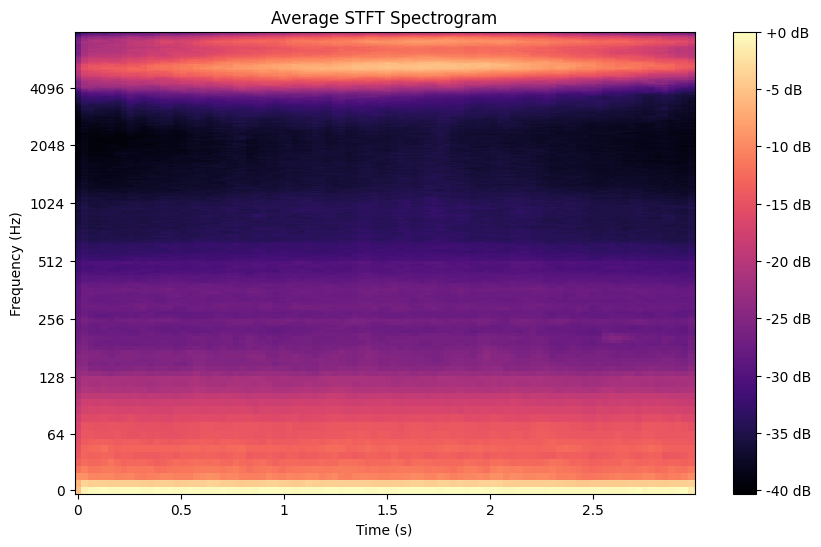

In [6]:
# Target
# Directory containing the audio files
audio_dir = '../datasets/training/target/*.wav'
file_paths = glob.glob(audio_dir)

# Load audio files and compute STFTs
stfts, sr = load_and_process_audio_files(file_paths)

# Compute the average STFT
target_avg_stft = average_stft(stfts)
target_avg_stft_db = librosa.amplitude_to_db(target_avg_stft, ref=np.max)

# Plot the average STFT spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(target_avg_stft_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Average STFT Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

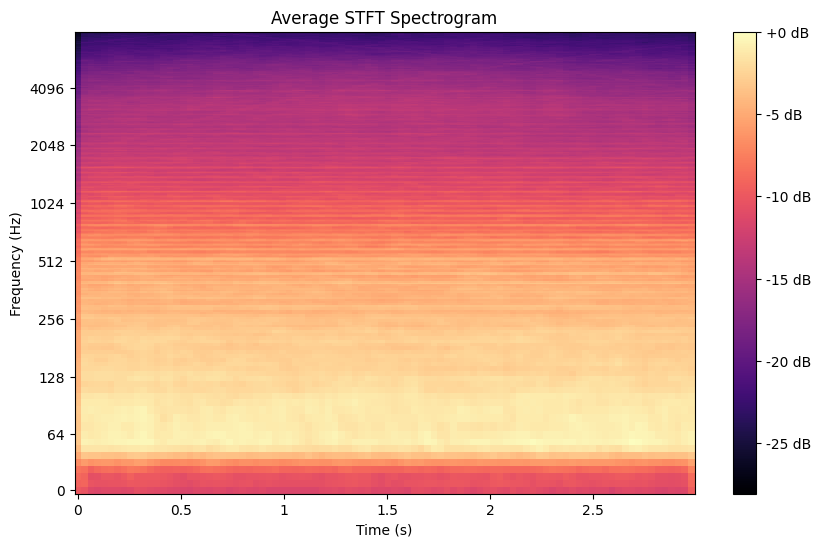

In [7]:
# Non-Target
# Directory containing the audio files
audio_dir = '../datasets/training/non_target/*.wav'
file_paths = glob.glob(audio_dir)

# Load audio files and compute STFTs
stfts, sr = load_and_process_audio_files(file_paths)

# Compute the average STFT
non_target_avg_stft = average_stft(stfts)
non_target_avg_stft_db = librosa.amplitude_to_db(non_target_avg_stft, ref=np.max)

# Plot the average STFT spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(non_target_avg_stft_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Average STFT Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

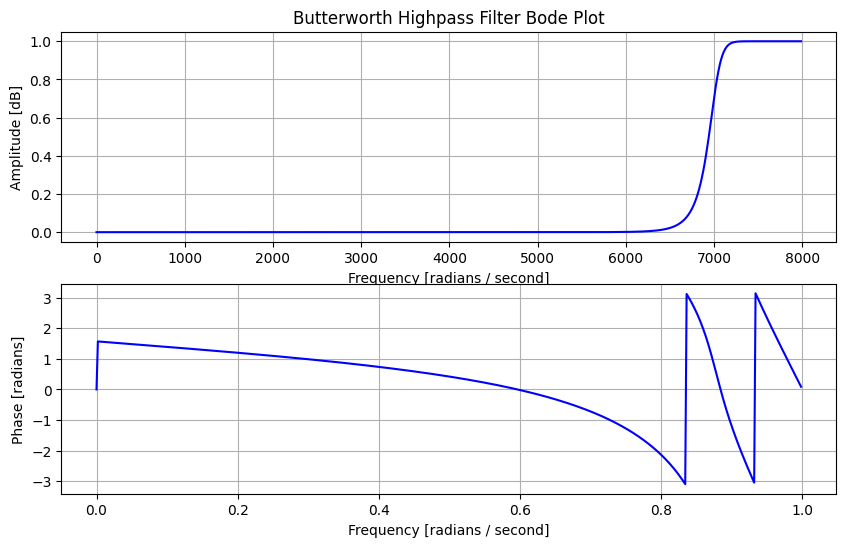

[[ 1.55854712e-07 -3.11709423e-07  1.55854712e-07  1.00000000e+00
   6.68178638e-01  0.00000000e+00]
 [ 1.00000000e+00 -2.00000000e+00  1.00000000e+00  1.00000000e+00
   1.35904130e+00  4.71015698e-01]
 [ 1.00000000e+00 -2.00000000e+00  1.00000000e+00  1.00000000e+00
   1.42887946e+00  5.46607979e-01]
 [ 1.00000000e+00 -2.00000000e+00  1.00000000e+00  1.00000000e+00
   1.55098998e+00  6.78779458e-01]
 [ 1.00000000e+00 -1.00000000e+00  0.00000000e+00  1.00000000e+00
   1.73262236e+00  8.75376926e-01]]


In [86]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, freqs, sosfreqz

# Function to design a Butterworth highpass filter
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    sos = butter(order, normal_cutoff, btype='high', analog=False, output='sos')
    return sos

# Parameters
cutoff = 7000  # Desired cutoff frequency of the filter, Hz
fs = RESAMPLE_RATE  # Sampling frequency, Hz
order = 9  # Order of the filter

# Design the Butterworth highpass filter
sos = butter_highpass(cutoff, fs, order)

# Compute the frequency response
w, h = sosfreqz(sos)

# Function to plot the Bode diagram
def plot_bode(w, h):
    plt.figure(figsize=(10, 6))
    
    # Magnitude plot
    plt.subplot(2, 1, 1)
#     plt.plot(w/np.pi, 20 * np.log10(abs(h)), 'b')
    plt.plot(w/np.pi * fs / 2, abs(h), 'b')

    plt.title('Butterworth Highpass Filter Bode Plot')
    plt.xlabel('Frequency [radians / second]')
    plt.ylabel('Amplitude [dB]')
    plt.grid(which='both', axis='both')

    # Phase plot
    plt.subplot(2, 1, 2)
    plt.plot(w/np.pi, np.angle(h), 'b')
    plt.xlabel('Frequency [radians / second]')
    plt.ylabel('Phase [radians]')
    plt.grid(which='both', axis='both')

    plt.show()

# Plot the Bode diagram
plot_bode(w, h)
print(sos)

In [22]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt
import librosa
import glob
from scipy.signal import butter, lfilter, sosfilt
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, precision_score, recall_score

# Function to design a Butterworth highpass filter and apply it to a signal
def butter_highpass_filter(data, sos):
    y = sosfilt(sos, data)
    return y

# Function to calculate the energy of a signal
def calculate_energy(signal):
    return np.sum(np.square(signal))

def calculate_mean_energy(signal):
    return np.mean(np.square(signal))

# Function to load and preprocess audio files, and calculate their energies
def load_and_preprocess_audio_files(file_paths, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    sos = butter(order, normal_cutoff, btype='high', analog=False, output='sos')
    
    energies = []
    for file_path in file_paths:
        y, sr = librosa.load(file_path, sr=fs)
        y, sr = resample_audio(y, sr)
        y = min_max_normalize_only_scale(y)
        y_filtered = butter_highpass_filter(y, sos)
        energy = calculate_mean_energy(y_filtered)
        energies.append(energy)
    return energies

# Function to classify signals based on energy threshold
def classify_signals(energies, threshold):
    classifications = ['bird' if energy > threshold else 'non-bird' for energy in energies]
    return classifications

# Parameters on fs 16000
# cutoff = 3932  # Desired cutoff frequency of the filter, Hz
# cutoff = 4500  # Desired cutoff frequency of the filter, Hz #Classification Metrics: Accuracy: 0.75 F1 Score: 0.65 F2 Score: 0.68
# cutoff = 5000 # Accuracy: 0.77 F1 Score: 0.67  F2 Score: 0.69
# cutoff = 6000 # Accuracy: 0.78 F1 Score: 0.68 F2 Score: 0.70
cutoff = 7000 # Accuracy: 0.80 F1 Score: 0.72 F2 Score: 0.74
# cutoff = 7500 # CAccuracy: 0.76 F1 Score: 0.66 F2 Score: 0.68

# Parameters on fs 32000
# cutoff = 7000 # Accuracy: 0.73 F1 Score: 0.64 F2 Score: 0.68
# cutoff = 3932 # Accuracy: 0.71 F1 Score: 0.61 F2 Score: 0.65
# cutoff = 8000

fs = RESAMPLE_RATE  # Sampling frequency, Hz
order = 9  # Order of the filter

# Directories containing the audio files
bird_audio_dir = '../datasets/testing/target/*.wav'
non_bird_audio_dir = '../datasets/testing/non_target//*.wav'

bird_file_paths = glob.glob(bird_audio_dir)
non_bird_file_paths = glob.glob(non_bird_audio_dir)

# True labels for the classification
true_labels = ['bird'] * len(bird_file_paths) + ['non-bird'] * len(non_bird_file_paths)

# Load, preprocess audio files, and calculate energies
bird_energies = load_and_preprocess_audio_files(bird_file_paths, cutoff, fs, order)
non_bird_energies = load_and_preprocess_audio_files(non_bird_file_paths, cutoff, fs, order)



/tmp/ipykernel_202470/2856164106.py:18: RuntimeWarning: invalid value encountered in divide
  normalized_signal = (signal) / (max_val - min_val)


In [92]:
import pickle
import pickle

# testing_energies_tlabels = {"bird": bird_energies, "non_bird": non_bird_energies, "labels": true_labels}

with open('testing_energies_tlabels.pkl', 'rb') as f:
    testing_energies_tlabels = pickle.load(f)
    
with open('training_energies_tlabels.pkl', 'rb') as f:
    training_energies_tlabels = pickle.load(f)

In [192]:

energies_tlabels = training_energies_tlabels
bird_energies = energies_tlabels["bird"]
non_bird_energies = energies_tlabels["non_bird"]
true_labels = energies_tlabels["labels"]

In [221]:
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, precision_score, recall_score

# energy_threshold = 2.3505878769676584e-05  # Example energy threshold for classification
energy_threshold = 2.00e-07 # low th
# energy_threshold = 2.294330745441582e-04  # high th


# Classify signals based on energy threshold
bird_classifications = classify_signals(bird_energies, energy_threshold)
non_bird_classifications = classify_signals(non_bird_energies, energy_threshold)

# Combine classifications
predicted_labels = bird_classifications + non_bird_classifications

# Compute accuracy, F1, and F2 scores
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, pos_label='bird')
f2 = fbeta_score(true_labels, predicted_labels, beta=2, pos_label='bird')
precision = precision_score(true_labels, predicted_labels, pos_label='bird')
recall = recall_score(true_labels, predicted_labels, pos_label='bird')

# Print classification results
def print_classification_results(file_paths, classifications):
    for file_path, classification in zip(file_paths, classifications):
        print(f"{file_path}: {classification}")

# print("Bird Group Classification:")
# print_classification_results(bird_file_paths, bird_classifications)

# print("\nNon-Bird Group Classification:")
# print_classification_results(non_bird_file_paths, non_bird_classifications)

# Print metrics
print("\nClassification Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"F2 Score: {f2:.2f}")
print(f"precision Score: {precision:.2f}")
print(f"recall Score: {recall:.2f}")


Classification Metrics:
Accuracy: 0.48
F1 Score: 0.56
F2 Score: 0.75
precision Score: 0.39
recall Score: 0.98


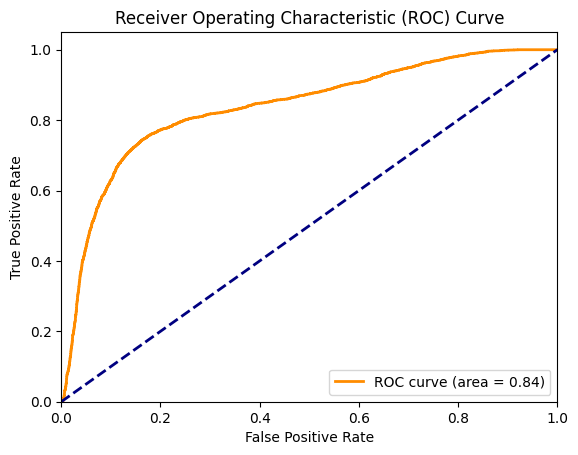

cutoff threshold:2.743189666943847e-05


In [213]:
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

def plot_roc_curve(true_labels, energies):
    true_binary_labels = [1 if label == 'bird' else 0 for label in true_labels]
    fpr, tpr, thresholds = roc_curve(true_binary_labels, energies)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    optimal_idx = np.argmax(tpr - fpr) # YJ index
#     optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr))) # gmeans
    optimal_threshold = thresholds[optimal_idx]
    print(f'cutoff threshold:{optimal_threshold}')
    return fpr, tpr, thresholds

# Combine energies from both groups
all_energies = bird_energies + non_bird_energies
fpr, tpr, thresholds = plot_roc_curve(true_labels, all_energies)

roc_curves = {"fpr": fpr, "tpr": tpr, "thresholds": thresholds}

with open('roc_curve_baseline_training.pkl', 'wb') as f:
    pickle.dump(roc_curves, f)

In [206]:
print(len(bird_energies))
print(len(non_bird_energies))


3806
7486


In [207]:
impulse_inp = np.zeros((20,))
impulse_inp[0] = 1.0
from scipy.signal import butter, lfilter, sosfilt
y = sosfilt(sos, impulse_inp)


In [208]:
y

array([ 1.55854712e-07, -2.45310823e-06,  1.89626610e-05, -9.64974612e-05,
        3.65706086e-04, -1.10700105e-03,  2.80204161e-03, -6.12660821e-03,
        1.18530452e-02, -2.06644128e-02,  3.29208522e-02, -4.84437903e-02,
        6.63861989e-02, -8.52377445e-02,  1.02979969e-01, -1.17369360e-01,
        1.26295369e-01, -1.28143184e-01,  1.22090123e-01, -1.08278721e-01])

In [209]:
sos

array([[ 1.55854712e-07, -3.11709423e-07,  1.55854712e-07,
         1.00000000e+00,  6.68178638e-01,  0.00000000e+00],
       [ 1.00000000e+00, -2.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.35904130e+00,  4.71015698e-01],
       [ 1.00000000e+00, -2.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.42887946e+00,  5.46607979e-01],
       [ 1.00000000e+00, -2.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.55098998e+00,  6.78779458e-01],
       [ 1.00000000e+00, -1.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  1.73262236e+00,  8.75376926e-01]])

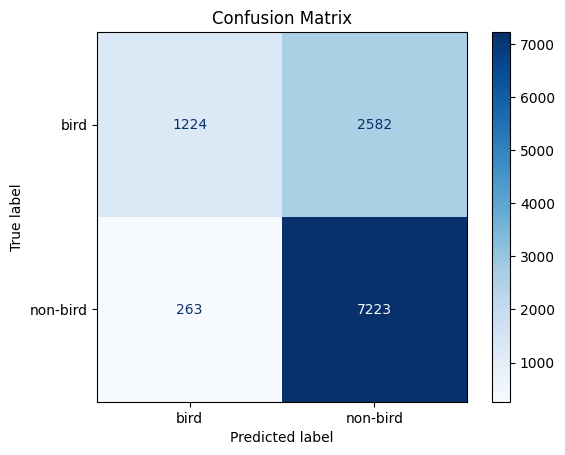

In [220]:
def plot_confusion_matrix(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels, labels=['bird', 'non-bird'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['bird', 'non-bird'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
    
plot_confusion_matrix(true_labels, predicted_labels)

In [48]:
def find_best_f2_threshold(true_labels, energies):
    best_threshold = None
    best_accuracy = 0
    thresholds = np.linspace(min(energies), max(energies), 1000)
    for threshold in thresholds:
        predicted_labels = classify_signals(energies, threshold)
        accuracy = fbeta_score(true_labels, predicted_labels, beta=2, pos_label='bird')
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold
    return best_threshold, best_accuracy

best_f2_threshold, best_f2 = find_best_f2_threshold(true_labels, all_energies)
print(f'best f2 th: {best_f2_threshold}, f2: {best_f2}')

best f2 th: 1.294330745441582e-05, f2: 0.755041075429425
